<a href="https://colab.research.google.com/github/pedro-cardoso16/Super-Resolution/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU

In [8]:
# Colab only
# download and install Pytorch
%pip install torch torchvision
%pip install numpy matplotlib

In [9]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F

import math


In [10]:

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [11]:
# load the image, convert it as an array of float, and divide to have [0,1] values
# path to the image on the drive
image_filename = "/content/gdrive/My Drive/foulard1-bis.jpg"

im = np.array(Image.open(image_filename), dtype=float)/255

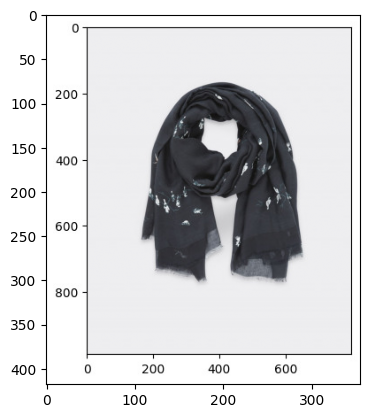

In [12]:
# display the original images
plt.figure()
plt.imshow(im)
plt.show()

In [13]:
# convert to torch with batch dimension as first dimension
image = torch.from_numpy(im.transpose(2,0,1)).float().unsqueeze(0)
print(image.shape)


torch.Size([1, 3, 418, 355])


## Neural network creation

The neural network is a Python class, it must inherit from the ```torch.nn.Module``` class of Pytorch.

It is composed of two main methods:
* ```__init__```, the contructor which define the layers to be used. The layers contain the paramters to be optimized
* ```forward```,  the method that define the links between the layers

As an example, we create a network based on UNet, a semantic segmeentation network.
This network has an encoder / decoder strcuture with skip connection.

To do Super Resolution, we simply use add a last block with one dimension augmentation (```upconv0```).

In [14]:
# create the neural network with Pytorch
class Mynet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Mynet, self).__init__()

    self.in_channels = in_channels

    self.conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(3)


  def forward(self, x):
    """Forward method."""

    x = F.relu(self.bn(self.conv(x)))
    x = F.relu(self.bn2(self.conv2(x)))

    return x

In [15]:
# actual network creation
net = Mynet(3,3)
net.cuda() # go GPU

image = image.cuda() # go gpu for the image data


## Optimization

There are two steps.
First we create the optimizer and then, we loop over the dataset (here, only one image) 1000 times and optimize the network weights.

In [16]:
# create the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

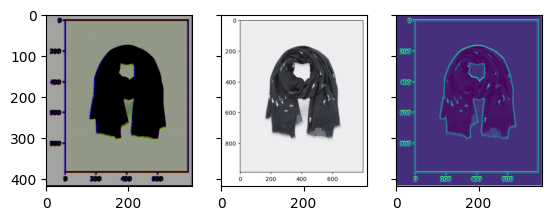

0.16026364266872406
0.1602453887462616
0.16022711992263794
0.16020889580249786
0.16019073128700256
0.16017256677150726
0.16015443205833435
0.16013632714748383
0.16011829674243927
0.1601002812385559
0.16008226573467255
0.16006429493427277
0.16004638373851776
0.16002847254276276
0.16001056134700775
0.1599927395582199
0.15997491776943207
0.15995711088180542
0.15993934869766235
0.15992163121700287
0.15990397334098816
0.15988625586032867
0.15986862778663635
0.15985102951526642
0.15983343124389648
0.15981587767601013
0.15979836881160736
0.1597808599472046
0.1597633957862854
0.1597459614276886
0.1597285270690918
0.15971116721630096
0.15969380736351013
0.15967649221420288
0.15965919196605682
0.15964189171791077
0.1596246361732483
0.1596074253320694
0.1595902144908905
0.15957306325435638
0.15955591201782227
0.15953880548477173
0.15952172875404358
0.15950468182563782
0.15948766469955444
0.15947070717811584
0.15945371985435486
0.15943679213523865
0.15941986441612244
0.159402996301651
0.1593861430

In [17]:
# Epoch loops (the number of times we see the training dataset)
for i in range(1000):

  for j in range(1): # iterate over the dataset (here one single image, should be more)

    # forward pass, compute the output of the network




    outputs = net(image)

    # compute the error (here mean square error)
    loss = F.mse_loss(outputs, image)

    # reinitialize the gradients
    optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # update the weights
    optimizer.step()

    print(loss.item())

  # display the results
  if i%100 == 0:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    clear_output(wait=True)
    outputs_np = outputs.cpu().detach().numpy()[0].transpose(1,2,0)
    ax1.imshow(np.clip(outputs_np,0,1))
    ax2.imshow(im)
    ax3.imshow(((outputs_np-im)**2).sum(axis=2))
    plt.show()


# Denoising of data set

In [19]:

%ls gdrive/My\ Drive/Images

101085.jpg  109053.jpg  145086.jpg  167062.jpg  197017.jpg  229036.jpg  285079.jpg  304074.jpg
101087.jpg  119082.jpg  147091.jpg  167083.jpg  208001.jpg  236037.jpg  291000.jpg  306005.jpg
102061.jpg  12084.jpg   148026.jpg  170057.jpg  210088.jpg  24077.jpg   295087.jpg  3096.jpg
103070.jpg  123074.jpg  148089.jpg  175032.jpg  21077.jpg   241004.jpg  296007.jpg  33039.jpg
105025.jpg  126007.jpg  157055.jpg  175043.jpg  216081.jpg  241048.jpg  296059.jpg  351093.jpg
106024.jpg  130026.jpg  159008.jpg  182053.jpg  219090.jpg  253027.jpg  299086.jpg
108005.jpg  134035.jpg  160068.jpg  189080.jpg  220075.jpg  253055.jpg  300091.jpg
108070.jpg  14037.jpg   16077.jpg   19021.jpg   223061.jpg  260058.jpg  302008.jpg
108082.jpg  143090.jpg  163085.jpg  196073.jpg  227092.jpg  271035.jpg  304034.jpg


In [ ]:
# create the neural network with Pytorch
class Mynet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Mynet, self).__init__()

    # input channels
    self.in_channels = in_channels

    self.conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(3)


  def forward(self, x):
    """Forward method."""

    x = F.relu(self.bn(self.conv(x)))
    x = F.relu(self.bn2(self.conv2(x)))

    return x